In [1]:
#import
from pandas.errors import SettingWithCopyWarning
from pyro.infer import MCMC, NUTS
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import warnings


# for CI testing
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [2]:
# Extract morphing level and shock (binary morphing level)

# Equal for all subjects
df = pd.read_csv('../data/newLookAtMe/newLookAtMe20.csv')
data = df[['morphing level', 'shock']]
data['shock'] = data['shock'].astype(int)
data['morphing level'] = [int(d==6) for d in data['morphing level']]

Create tensor where:
* `[0 0] = 0`
* `[1 0] = 1`
* `[1 1] = 2`

In [3]:
data_model = data.to_numpy()
data_final = []
for x in data_model:
    if (x == [0, 0]).all():
        data_final.append(0)
    elif (x == [1, 0]).all():
        data_final.append(1)
    else:
        data_final.append(2)

data_final = torch.tensor(data_final)
data_model_tensor = torch.tensor(data_model)
data_model_tensor.shape

torch.Size([160, 2])

$p(data\, final | \theta) = \prod_i^3\theta_k^{N_k}$

where $\theta$ is a vector 3-dimensional modeled with a Dirichlet Distribution

In [4]:
data_model

array([[0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0,

In [5]:
# model definition

# uniform prior
prior_counts = torch.ones((2,2))

def simple_model(data):
    theta = pyro.sample("theta", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, theta), obs=data)

counter = torch.tensor(np.unique(data_model, axis=0, return_counts=True)[1])
counter_prova = torch.tensor([[28, 0], [5,15]])

In [6]:
nuts_kernel = NUTS(simple_model)
num_samples, warmup_steps = (1000, 200) if not smoke_test else (10, 10)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(counter_prova)
hmc_samples = {k: v.detach().cpu().numpy()
               for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:11, 103.50it/s, step size=7.24e-01, acc. prob=0.908]


In [7]:
not_agg_data = data_model_tensor[data_model_tensor[:,0] == 0]
agg_data = data_model_tensor[data_model_tensor[:,0] == 1]


In [8]:
data_model_tensor.shape

torch.Size([160, 2])

In [9]:
np.unique(agg_data, return_counts=True, axis=0)[1]

array([28, 28])

In [10]:
prior_aggressive = torch.ones(2)
prior_not_aggressive = torch.ones(2)

def model(data):
    not_agg_data = data[data[:,0] == 0]
    agg_data = data[data[:,0] == 1]

    count_values_1 = torch.tensor(np.append(np.unique(not_agg_data, return_counts=True, axis=0)[1], 0))
    count_values_2 = torch.tensor(np.unique(agg_data, return_counts=True, axis=0)[1])

    theta1 = pyro.sample("theta1", dist.Dirichlet(prior_aggressive))
    theta2 = pyro.sample("theta2", dist.Dirichlet(prior_not_aggressive))

    counts1 = int(count_values_1.sum())
    counts2 = int(count_values_2.sum())

    pyro.sample("likelihood1", dist.Multinomial(counts1, theta1), obs = count_values_1)
    pyro.sample("likelihood2", dist.Multinomial(counts2, theta2), obs = count_values_2)



In [11]:
nuts_kernel = NUTS(model)
num_samples, warmup_steps = (1000, 200) if not smoke_test else (10, 10)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data_model_tensor[16:48])
hmc_samples = {k: v.detach().cpu().numpy()
               for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:18, 66.27it/s, step size=9.04e-01, acc. prob=0.912]


In [12]:
dist_cs_minus = hmc_samples['theta1'].mean(axis=0)
dist_cs_plus = hmc_samples['theta2'].mean(axis=0)
print(dist_cs_minus)
print(dist_cs_plus)

[0.9465429  0.05345723]
[0.27769166 0.722309  ]


La cella sopra indica le probabilità di vedere una coppia `[0 0]`, una coppia `[1 0]` o una coppia `[1 1]`, ma non $P(shock | morph\, level)$.

In [13]:
x_test, y_test = data_model_tensor[48:,0], data_model_tensor[48:,1]
y_test

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
unique_values = torch.unique(x_test, return_counts = True)[1]
shock = unique_values[1]
no_shock = unique_values[0]
# predictive
prediction = torch.tensor([])
for i in x_test:
    if int(i) == 0:
        prediction = torch.cat((prediction, dist.Bernoulli(torch.tensor([dist_cs_minus[1]])).sample()))
    else:
        prediction = torch.cat((prediction, dist.Bernoulli(torch.tensor([dist_cs_plus[1]])).sample()))


prediction = np.array(prediction)
prediction.shape

(112,)

## Results check

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyirr import intraclass_correlation
from fear_gen.extract_correct_csv import extract_only_valid_subject, read_correct_subject_csv, anxious_subjects


correlation_df = pd.DataFrame(columns=['Subject', 'ICC', 'Accuracy Score', 'Precision', 'Recall', 'F1 score'])
os.chdir('..')
valid_subjects = extract_only_valid_subject()
os.chdir('pyro')

for i in valid_subjects:
    subj_ = read_correct_subject_csv(i)
    df_sub = pd.read_csv('../data/newLookAtMe/newLookAtMe'+subj_+'.csv')
    df_sub = df_sub[48:]
    rating = [int(d > 2) for d in df_sub['rating']]
    bad = ~np.logical_or(np.isnan(rating), np.isnan(prediction))
    rating_sub = np.compress(bad, rating)
    rating_rational = np.compress(bad, prediction)

    icc_df = pd.DataFrame()
    icc_df['Rating'] = rating_sub
    icc_df['Prediction'] = rating_rational

    icc = intraclass_correlation(icc_df).value
    accuracy_ = accuracy_score(rating_sub, rating_rational)
    precision_ = precision_score(rating_sub, rating_rational)
    recall_ = recall_score(rating_sub, rating_rational)
    f1_ = f1_score(rating_sub, rating_rational)

    df_tmp = pd.DataFrame({'Subject':i,'ICC':icc,'Accuracy Score':accuracy_,'Precision':precision_,'Recall':recall_, 'F1 score':f1_},index=np.arange(1))
    correlation_df = pd.concat([correlation_df,df_tmp])

correlation_df

,Subject,ICC,Accuracy Score,Precision,Recall,F1 score
0,1,0.075350,0.607143,0.444444,0.292683,0.352941
0,2,0.334076,0.687500,0.888889,0.428571,0.578313
0,4,0.136187,0.589286,0.740741,0.338983,0.465116
0,5,0.398374,0.732143,0.814815,0.468085,0.594595
0,6,0.418087,0.785714,0.555556,0.555556,0.555556
0,7,0.295983,0.678571,0.777778,0.411765,0.538462
0,13,0.097561,0.562500,0.777778,0.328125,0.461538
0,15,0.273812,0.696429,0.592593,0.410256,0.484848
0,16,0.182504,0.633929,0.629630,0.354167,0.453333
0,17,-0.073959,0.473214,0.666667,0.264706,0.378947


In [16]:
lds_path = '../data/lds_subjects.csv'
sias_path = '../data/sias_score.csv'

high_lds = anxious_subjects(lds_path, n=6, type_='top')
low_lds = anxious_subjects(lds_path, n=6, type_='bot')
high_sias = anxious_subjects(lds_path, n=6, type_='top')
low_sias = anxious_subjects(sias_path, n=6, type_='bot')


In [17]:
lds_df = pd.read_csv(lds_path)
sias_df = pd.read_csv(sias_path)
lds_values = lds_df[lds_df.subject.isin(valid_subjects)]['lds'].values
sias_values = sias_df[sias_df.subject.isin(valid_subjects)]['sias_score'].values

correlation_df['SIAS'] = sias_values
correlation_df['LDS'] = lds_values

In [18]:
from sklearn.linear_model import LinearRegression

x_ = correlation_df['LDS'].values[:,np.newaxis]
y_ = correlation_df['F1 score'].values

reg = LinearRegression()
reg.fit(x_, y_)
predict = reg.predict(x_)


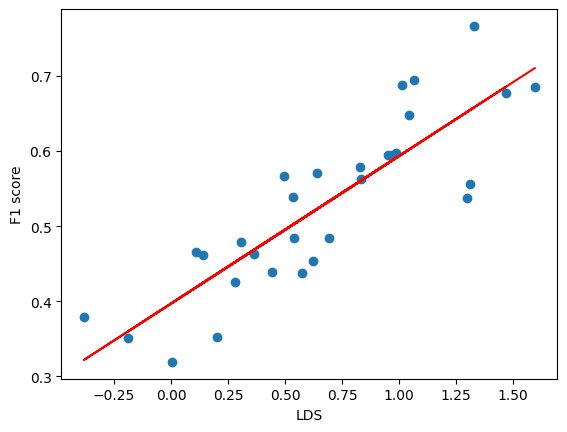

In [19]:
plt.scatter(x_, y_,)
plt.plot(x_, predict, color='red')
plt.xlabel('LDS')
plt.ylabel('F1 score')
plt.show()